In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import json
import pickle

import xgboost as xgb
print("xgb.__version__:", xgb.__version__)

# local modules
import sys
sys.path.append("../src")
from preproc import process_train_data, process_test_data

xgb.__version__: 2.1.1


***
### load and preprocess data

In [2]:
# define some paths
path_raw = Path("../data/raw")
path_processed = Path("../data/processed")
path_results = Path("../data/results")

# load data
df_train = pd.read_csv(path_raw / "train.csv")
df_test = pd.read_csv(path_raw / "test.csv")

df_train

,Id,GameRulesetName,agent1,agent2,Properties,Format,Time,Discrete,Realtime,Turns,...,DoLudeme,Trigger,PlayoutsPerSecond,MovesPerSecond,EnglishRules,LudRules,num_wins_agent1,num_draws_agent1,num_losses_agent1,utility_agent1
0,0,00Y,MCTS-ProgressiveHistory-0.1-MAST-false,MCTS-ProgressiveHistory-0.6-Random200-false,1,1,1,1,0,1,...,0,1,298.07,18877.17,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",4,0,11,-0.466667
1,1,00Y,MCTS-ProgressiveHistory-0.1-MAST-false,MCTS-UCB1GRAVE-0.6-NST-true,1,1,1,1,0,1,...,0,1,298.07,18877.17,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",5,0,10,-0.333333
2,2,00Y,MCTS-ProgressiveHistory-0.1-MAST-true,MCTS-UCB1-0.1-NST-false,1,1,1,1,0,1,...,0,1,298.07,18877.17,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",7,0,8,-0.066667
3,3,00Y,MCTS-ProgressiveHistory-0.1-MAST-true,MCTS-UCB1-0.6-NST-false,1,1,1,1,0,1,...,0,1,298.07,18877.17,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",5,0,10,-0.333333
4,4,00Y,MCTS-ProgressiveHistory-0.1-MAST-true,MCTS-UCB1GRAVE-1.41421356237-NST-false,1,1,1,1,0,1,...,0,1,298.07,18877.17,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",5,0,10,-0.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233229,233229,Zuz_Mel_7x7,MCTS-UCB1Tuned-1.41421356237-NST-false,MCTS-ProgressiveHistory-1.41421356237-Random20...,1,1,1,1,0,1,...,0,0,157.52,157174.58,7x7 board. 24 pieces per player. Pieces begin ...,"(game ""Zuz Mel (7x7)"" (players 2) (equipment {...",2,0,13,-0.733333
233230,233230,Zuz_Mel_7x7,MCTS-UCB1Tuned-1.41421356237-Random200-false,MCTS-UCB1-0.6-MAST-false,1,1,1,1,0,1,...,0,0,157.52,157174.58,7x7 board. 24 pieces per player. Pieces begin ...,"(game ""Zuz Mel (7x7)"" (players 2) (equipment {...",9,1,5,0.266667
233231,233231,Zuz_Mel_7x7,MCTS-UCB1Tuned-1.41421356237-Random200-false,MCTS-UCB1GRAVE-1.41421356237-NST-false,1,1,1,1,0,1,...,0,0,157.52,157174.58,7x7 board. 24 pieces per player. Pieces begin ...,"(game ""Zuz Mel (7x7)"" (players 2) (equipment {...",11,3,1,0.666667
233232,233232,Zuz_Mel_7x7,MCTS-UCB1Tuned-1.41421356237-Random200-false,MCTS-UCB1GRAVE-1.41421356237-NST-true,1,1,1,1,0,1,...,0,0,157.52,157174.58,7x7 board. 24 pieces per player. Pieces begin ...,"(game ""Zuz Mel (7x7)"" (players 2) (equipment {...",24,2,4,0.666667


In [3]:
# input parameters
fs_type = 'fsv24'
train_type = "small"

In [4]:
# Parameters
fs_type = "uni95"


In [5]:
# Load the feature selection results
fs_mapping = {
    "full": None,
    "fsv2": '../feat_selection/select_optuna_lgbm_v2.json',
    "fsv3": '../feat_selection/select_optuna_catb.json',
    "fsv4": '../feat_selection/select_optuna_lgbm_v3.json',
    "fsv23": '../feat_selection/select_optuna_combined_v23.json',
    "fsv24": '../feat_selection/select_optuna_combined_v24.json',
    "fsv34": '../feat_selection/select_optuna_combined_v34.json',
    "int95": '../feat_selection/feat_selection_intersection_at_95.json',
    "int96": '../feat_selection/feat_selection_intersection_at_96.json',
    "int97": '../feat_selection/feat_selection_intersection_at_97.json',
    "int98": '../feat_selection/feat_selection_intersection_at_98.json',
    "int99": '../feat_selection/feat_selection_intersection_at_99.json',
    "uni80": '../feat_selection/feat_selection_union_at_80.json',
    "uni85": '../feat_selection/feat_selection_union_at_85.json',
    "uni90": '../feat_selection/feat_selection_union_at_90.json',
    "uni95": '../feat_selection/feat_selection_union_at_95.json',
}

fs_path = fs_mapping[fs_type]

if fs_path is None:
    feature_selection = dict()
else:
    with open(fs_path, 'r') as f:
        feature_selection = json.load(f)

# Extract the selected features
numerical_cols = feature_selection.get('numerical', None)
categorical_cols = feature_selection.get('categorical', None)

# text_cols = ["LudRules",]
text_cols = list()

print("Numerical features:", len(numerical_cols) if numerical_cols else 0)
print("Categorical features:", len(categorical_cols) if categorical_cols else 0)
print("Text features:", len(text_cols) if text_cols else 0)

Numerical features: 396
Categorical features: 10
Text features: 0


In [6]:
df_train, numerical_cols, categorical_cols, encoder, scaler = process_train_data(
    df_train,
    scale=False,
    numerical_cols=numerical_cols,
    categorical_cols=categorical_cols,
    include_position_features=True,
    include_text_features=False,
)

# Print the results
print("Numerical Columns:", len(numerical_cols))
print("Categorical Columns:", len(categorical_cols))

number of all nan cols:  0


number of constant cols:  0


Numerical Columns: 468
Categorical Columns: 10


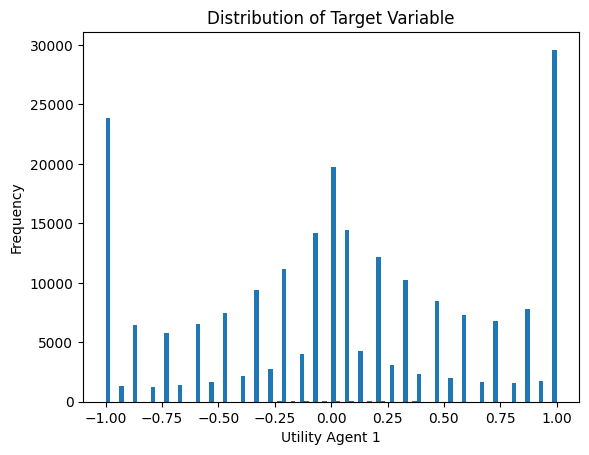

In [7]:
plt.hist(df_train['utility_agent1'], bins=100)
plt.title('Distribution of Target Variable')
plt.xlabel('Utility Agent 1')
plt.ylabel('Frequency')
plt.show()

In [8]:
split1 = pickle.load(open('../data/splits/cv1_Game.pkl', 'rb'))
split2 = pickle.load(open('../data/splits/cv2_Game.pkl', 'rb'))
split3 = pickle.load(open('../data/splits/cv3_Game.pkl', 'rb'))

# split1 = pickle.load(open('../data/splits/cv1_GameRulesetName.pkl', 'rb'))
# split2 = pickle.load(open('../data/splits/cv2_GameRulesetName.pkl', 'rb'))
# split3 = pickle.load(open('../data/splits/cv3_GameRulesetName.pkl', 'rb'))

***
### train model


In [9]:
if train_type == "small":
    LEARNING_RATE = 0.03
    NUM_BOOST_ROUND = 2500
elif train_type == "medium":
    LEARNING_RATE = 0.01
    NUM_BOOST_ROUND = 5000
elif train_type == "large":
    LEARNING_RATE = 0.005
    NUM_BOOST_ROUND = 10_000
elif train_type == "xlarge":
    LEARNING_RATE = 0.001
    NUM_BOOST_ROUND = 20_000


print(LEARNING_RATE, NUM_BOOST_ROUND)

0.03 2500


In [10]:
def train_models(
        df_train,
        target,
        numerical_cols,
        categorical_cols,
        split_list=None
    ):
    # Define the parameters
    params = {
        'objective': "reg:squarederror",
        'eval_metric': 'rmse',
        'max_depth': 8,
        'max_bin': 128,
        'learning_rate': LEARNING_RATE,
        'alpha': 0.1,
        'colsample_bytree': 0.5,
        'subsample': 0.8,
        'min_child_weight': 10,
        'seed': 2112,
        'verbosity': 0,
    }

    trained_models = []
    oof = pd.DataFrame(
        index=df_train.index,
        columns=[f'{target}_true', f'{target}_pred', 'fold']
    )
    oof_scores = []
    feat_importance_dfs = []

    # Perform cross-validation
    for fold, (train_index, val_index) in enumerate(split_list, 1):
        print(f"Fold {fold}")
        
        # Split the data
        X_train, X_val = df_train.iloc[train_index], df_train.iloc[val_index]
        y_train, y_val = X_train[target], X_val[target]

        feature_types = [
            "c" if col in categorical_cols else "q" 
            for col in numerical_cols + categorical_cols
        ]
        
        # Convert to DMatrix format
        train_data = xgb.DMatrix(
            data=X_train[numerical_cols + categorical_cols],
            label=y_train,
            feature_types=feature_types,
            enable_categorical=True,
            feature_names=numerical_cols + categorical_cols
        )
        val_data = xgb.DMatrix(
            data=X_val[numerical_cols + categorical_cols],
            label=y_val,
            feature_types=feature_types,
            enable_categorical=True,
            feature_names=numerical_cols + categorical_cols
        )

        # Train the model
        model = xgb.train(
            params,
            train_data,
            num_boost_round=NUM_BOOST_ROUND,
            evals=[(val_data, 'val')],
            verbose_eval=100,
        )
        
        # Get feature importance
        importance_dict = model.get_score(importance_type='gain')
        feat_importance = pd.DataFrame(
            {'feature': list(importance_dict.keys()),
             f'importance_f{fold}': list(importance_dict.values())}
        )
        feat_importance_dfs.append(feat_importance)
        
        # Save the trained model to the list
        trained_models.append(model)

        # predict on validation set
        y_pred = model.predict(val_data)

        # Save out-of-fold predictions
        oof.loc[val_index, f'{target}_true'] = y_val
        oof.loc[val_index, f'{target}_pred'] = y_pred
        oof.loc[val_index, 'fold'] = fold

        # Compute RMSE
        y_pred = np.clip(y_pred, -1, 1)
        rmse = np.sqrt(np.mean((y_pred - y_val) ** 2))
        print(f"Fold {fold} - RMSE: {rmse}")

        # Save RMSE to the list
        oof_scores.append(rmse)

    # Combine feature importance dataframes
    importance_df = feat_importance_dfs[0]
    for df in feat_importance_dfs[1:]:
        importance_df = importance_df.merge(df, on='feature')
    
    # Calculate mean importance across folds
    importance_cols = [col for col in importance_df.columns if col.startswith('importance_f')]
    importance_df['importance_mean'] = importance_df[importance_cols].mean(axis=1)
    importance_df = importance_df.sort_values('importance_mean', ascending=False, ignore_index=True)
    importance_df['importance_relative'] = (
        importance_df['importance_mean'] / 
        importance_df['importance_mean'].sum()
    )

    # Print the list of oof scores and average oof score
    print("List of oof scores:", oof_scores)
    print("Average oof score:", np.mean(oof_scores))

    return trained_models, oof, oof_scores, importance_df

In [11]:
# call the function
trained_models1, oof1, oof_scores1, importance_df1 = train_models(
    df_train,
    'utility_agent1',
    numerical_cols,
    categorical_cols,
    split_list=split1,
)
# save oof predictions
oof1.to_parquet(path_results / f'oof_xgboost_{fs_type}_cv1.parquet', index=False)

Fold 1


[0]	val-rmse:0.55259


[100]	val-rmse:0.47030


[200]	val-rmse:0.45359


[300]	val-rmse:0.44506


[400]	val-rmse:0.43960


[500]	val-rmse:0.43675


[600]	val-rmse:0.43467


[700]	val-rmse:0.43330


[800]	val-rmse:0.43215


[900]	val-rmse:0.43137


[1000]	val-rmse:0.43097


[1100]	val-rmse:0.43052


[1200]	val-rmse:0.43019


[1300]	val-rmse:0.42997


[1400]	val-rmse:0.42992


[1500]	val-rmse:0.42964


[1600]	val-rmse:0.42944


[1700]	val-rmse:0.42941


[1800]	val-rmse:0.42929


[1900]	val-rmse:0.42921


[2000]	val-rmse:0.42922


[2100]	val-rmse:0.42908


[2200]	val-rmse:0.42904


[2300]	val-rmse:0.42902


[2400]	val-rmse:0.42897


[2499]	val-rmse:0.42901


Fold 1 - RMSE: 0.4286935851094908
Fold 2


[0]	val-rmse:0.58662


[100]	val-rmse:0.48055


[200]	val-rmse:0.46677


[300]	val-rmse:0.45983


[400]	val-rmse:0.45518


[500]	val-rmse:0.45232


[600]	val-rmse:0.45042


[700]	val-rmse:0.44928


[800]	val-rmse:0.44831


[900]	val-rmse:0.44769


[1000]	val-rmse:0.44694


[1100]	val-rmse:0.44657


[1200]	val-rmse:0.44617


[1300]	val-rmse:0.44558


[1400]	val-rmse:0.44551


[1500]	val-rmse:0.44535


[1600]	val-rmse:0.44525


[1700]	val-rmse:0.44495


[1800]	val-rmse:0.44484


[1900]	val-rmse:0.44484


[2000]	val-rmse:0.44462


[2100]	val-rmse:0.44469


[2200]	val-rmse:0.44465


[2300]	val-rmse:0.44450


[2400]	val-rmse:0.44432


[2499]	val-rmse:0.44437


Fold 2 - RMSE: 0.44396350988120964
Fold 3


[0]	val-rmse:0.60274


[100]	val-rmse:0.48084


[200]	val-rmse:0.46232


[300]	val-rmse:0.45363


[400]	val-rmse:0.44892


[500]	val-rmse:0.44558


[600]	val-rmse:0.44380


[700]	val-rmse:0.44233


[800]	val-rmse:0.44136


[900]	val-rmse:0.44060


[1000]	val-rmse:0.44022


[1100]	val-rmse:0.43966


[1200]	val-rmse:0.43919


[1300]	val-rmse:0.43878


[1400]	val-rmse:0.43868


[1500]	val-rmse:0.43856


[1600]	val-rmse:0.43840


[1700]	val-rmse:0.43829


[1800]	val-rmse:0.43823


[1900]	val-rmse:0.43826


[2000]	val-rmse:0.43824


[2100]	val-rmse:0.43815


[2200]	val-rmse:0.43804


[2300]	val-rmse:0.43797


[2400]	val-rmse:0.43799


[2499]	val-rmse:0.43803


Fold 3 - RMSE: 0.43756240691352855
Fold 4


[0]	val-rmse:0.59416


[100]	val-rmse:0.48338


[200]	val-rmse:0.46415


[300]	val-rmse:0.45615


[400]	val-rmse:0.45087


[500]	val-rmse:0.44775


[600]	val-rmse:0.44547


[700]	val-rmse:0.44408


[800]	val-rmse:0.44303


[900]	val-rmse:0.44248


[1000]	val-rmse:0.44185


[1100]	val-rmse:0.44126


[1200]	val-rmse:0.44084


[1300]	val-rmse:0.44042


[1400]	val-rmse:0.44027


[1500]	val-rmse:0.44012


[1600]	val-rmse:0.43998


[1700]	val-rmse:0.43990


[1800]	val-rmse:0.43962


[1900]	val-rmse:0.43945


[2000]	val-rmse:0.43930


[2100]	val-rmse:0.43913


[2200]	val-rmse:0.43903


[2300]	val-rmse:0.43894


[2400]	val-rmse:0.43894


[2499]	val-rmse:0.43892


Fold 4 - RMSE: 0.43848742672153346
Fold 5


[0]	val-rmse:0.54675


[100]	val-rmse:0.45440


[200]	val-rmse:0.43520


[300]	val-rmse:0.42602


[400]	val-rmse:0.41940


[500]	val-rmse:0.41545


[600]	val-rmse:0.41302


[700]	val-rmse:0.41156


[800]	val-rmse:0.41018


[900]	val-rmse:0.40934


[1000]	val-rmse:0.40870


[1100]	val-rmse:0.40798


[1200]	val-rmse:0.40766


[1300]	val-rmse:0.40738


[1400]	val-rmse:0.40734


[1500]	val-rmse:0.40694


[1600]	val-rmse:0.40697


[1700]	val-rmse:0.40684


[1800]	val-rmse:0.40685


[1900]	val-rmse:0.40675


[2000]	val-rmse:0.40661


[2100]	val-rmse:0.40665


[2200]	val-rmse:0.40670


[2300]	val-rmse:0.40673


[2400]	val-rmse:0.40668


[2499]	val-rmse:0.40676


Fold 5 - RMSE: 0.40645696388295693
List of oof scores: [0.4286935851094908, 0.44396350988120964, 0.43756240691352855, 0.43848742672153346, 0.40645696388295693]
Average oof score: 0.4310327785017439


In [12]:
# call the function
trained_models2, oof2, oof_scores2, importance_df2 = train_models(
    df_train,
    'utility_agent1',
    numerical_cols,
    categorical_cols,
    split_list=split2,
)
# save oof predictions
oof2.to_parquet(path_results / f'oof_xgboost_{fs_type}_cv2.parquet', index=False)

Fold 1


[0]	val-rmse:0.53406


[100]	val-rmse:0.45528


[200]	val-rmse:0.43948


[300]	val-rmse:0.43229


[400]	val-rmse:0.42750


[500]	val-rmse:0.42470


[600]	val-rmse:0.42253


[700]	val-rmse:0.42137


[800]	val-rmse:0.42021


[900]	val-rmse:0.41937


[1000]	val-rmse:0.41887


[1100]	val-rmse:0.41833


[1200]	val-rmse:0.41791


[1300]	val-rmse:0.41743


[1400]	val-rmse:0.41711


[1500]	val-rmse:0.41675


[1600]	val-rmse:0.41668


[1700]	val-rmse:0.41653


[1800]	val-rmse:0.41643


[1900]	val-rmse:0.41637


[2000]	val-rmse:0.41626


[2100]	val-rmse:0.41627


[2200]	val-rmse:0.41633


[2300]	val-rmse:0.41628


[2400]	val-rmse:0.41614


[2499]	val-rmse:0.41610


Fold 1 - RMSE: 0.41588915600938536
Fold 2


[0]	val-rmse:0.54380


[100]	val-rmse:0.43209


[200]	val-rmse:0.41583


[300]	val-rmse:0.40991


[400]	val-rmse:0.40620


[500]	val-rmse:0.40452


[600]	val-rmse:0.40320


[700]	val-rmse:0.40254


[800]	val-rmse:0.40182


[900]	val-rmse:0.40123


[1000]	val-rmse:0.40127


[1100]	val-rmse:0.40105


[1200]	val-rmse:0.40103


[1300]	val-rmse:0.40090


[1400]	val-rmse:0.40105


[1500]	val-rmse:0.40083


[1600]	val-rmse:0.40090


[1700]	val-rmse:0.40102


[1800]	val-rmse:0.40109


[1900]	val-rmse:0.40112


[2000]	val-rmse:0.40129


[2100]	val-rmse:0.40138


[2200]	val-rmse:0.40161


[2300]	val-rmse:0.40168


[2400]	val-rmse:0.40178


[2499]	val-rmse:0.40181


Fold 2 - RMSE: 0.40125891324416835
Fold 3


[0]	val-rmse:0.61099


[100]	val-rmse:0.48824


[200]	val-rmse:0.46777


[300]	val-rmse:0.45763


[400]	val-rmse:0.45143


[500]	val-rmse:0.44746


[600]	val-rmse:0.44496


[700]	val-rmse:0.44329


[800]	val-rmse:0.44224


[900]	val-rmse:0.44118


[1000]	val-rmse:0.44048


[1100]	val-rmse:0.43976


[1200]	val-rmse:0.43935


[1300]	val-rmse:0.43908


[1400]	val-rmse:0.43880


[1500]	val-rmse:0.43845


[1600]	val-rmse:0.43822


[1700]	val-rmse:0.43816


[1800]	val-rmse:0.43802


[1900]	val-rmse:0.43785


[2000]	val-rmse:0.43771


[2100]	val-rmse:0.43768


[2200]	val-rmse:0.43752


[2300]	val-rmse:0.43751


[2400]	val-rmse:0.43734


[2499]	val-rmse:0.43723


Fold 3 - RMSE: 0.43683744662445545
Fold 4


[0]	val-rmse:0.60326


[100]	val-rmse:0.48321


[200]	val-rmse:0.46073


[300]	val-rmse:0.45207


[400]	val-rmse:0.44718


[500]	val-rmse:0.44455


[600]	val-rmse:0.44258


[700]	val-rmse:0.44128


[800]	val-rmse:0.44025


[900]	val-rmse:0.43944


[1000]	val-rmse:0.43852


[1100]	val-rmse:0.43790


[1200]	val-rmse:0.43753


[1300]	val-rmse:0.43717


[1400]	val-rmse:0.43682


[1500]	val-rmse:0.43642


[1600]	val-rmse:0.43617


[1700]	val-rmse:0.43597


[1800]	val-rmse:0.43582


[1900]	val-rmse:0.43579


[2000]	val-rmse:0.43564


[2100]	val-rmse:0.43553


[2200]	val-rmse:0.43538


[2300]	val-rmse:0.43532


[2400]	val-rmse:0.43524


[2499]	val-rmse:0.43518


Fold 4 - RMSE: 0.43482378090097773
Fold 5


[0]	val-rmse:0.58911


[100]	val-rmse:0.48435


[200]	val-rmse:0.46428


[300]	val-rmse:0.45564


[400]	val-rmse:0.44960


[500]	val-rmse:0.44617


[600]	val-rmse:0.44418


[700]	val-rmse:0.44248


[800]	val-rmse:0.44166


[900]	val-rmse:0.44095


[1000]	val-rmse:0.44036


[1100]	val-rmse:0.43983


[1200]	val-rmse:0.43958


[1300]	val-rmse:0.43933


[1400]	val-rmse:0.43905


[1500]	val-rmse:0.43882


[1600]	val-rmse:0.43867


[1700]	val-rmse:0.43855


[1800]	val-rmse:0.43843


[1900]	val-rmse:0.43823


[2000]	val-rmse:0.43826


[2100]	val-rmse:0.43811


[2200]	val-rmse:0.43817


[2300]	val-rmse:0.43818


[2400]	val-rmse:0.43810


[2499]	val-rmse:0.43815


Fold 5 - RMSE: 0.43767091608890074
List of oof scores: [0.41588915600938536, 0.40125891324416835, 0.43683744662445545, 0.43482378090097773, 0.43767091608890074]
Average oof score: 0.42529604257357756


In [13]:
# call the function
trained_models3, oof3, oof_scores3, importance_df3 = train_models(
    df_train,
    'utility_agent1',
    numerical_cols,
    categorical_cols,
    split_list=split3,
)
# save oof predictions
oof3.to_parquet(path_results / f'oof_xgboost_{fs_type}_cv3.parquet', index=False)

Fold 1


[0]	val-rmse:0.57397


[100]	val-rmse:0.47846


[200]	val-rmse:0.45887


[300]	val-rmse:0.45067


[400]	val-rmse:0.44620


[500]	val-rmse:0.44370


[600]	val-rmse:0.44183


[700]	val-rmse:0.44081


[800]	val-rmse:0.43979


[900]	val-rmse:0.43915


[1000]	val-rmse:0.43867


[1100]	val-rmse:0.43855


[1200]	val-rmse:0.43827


[1300]	val-rmse:0.43793


[1400]	val-rmse:0.43782


[1500]	val-rmse:0.43753


[1600]	val-rmse:0.43747


[1700]	val-rmse:0.43738


[1800]	val-rmse:0.43732


[1900]	val-rmse:0.43729


[2000]	val-rmse:0.43717


[2100]	val-rmse:0.43719


[2200]	val-rmse:0.43707


[2300]	val-rmse:0.43702


[2400]	val-rmse:0.43712


[2499]	val-rmse:0.43717


Fold 1 - RMSE: 0.4367606822491662
Fold 2


[0]	val-rmse:0.57238


[100]	val-rmse:0.46894


[200]	val-rmse:0.44659


[300]	val-rmse:0.43622


[400]	val-rmse:0.43031


[500]	val-rmse:0.42662


[600]	val-rmse:0.42426


[700]	val-rmse:0.42237


[800]	val-rmse:0.42107


[900]	val-rmse:0.42006


[1000]	val-rmse:0.41923


[1100]	val-rmse:0.41848


[1200]	val-rmse:0.41795


[1300]	val-rmse:0.41765


[1400]	val-rmse:0.41735


[1500]	val-rmse:0.41718


[1600]	val-rmse:0.41703


[1700]	val-rmse:0.41684


[1800]	val-rmse:0.41671


[1900]	val-rmse:0.41658


[2000]	val-rmse:0.41650


[2100]	val-rmse:0.41629


[2200]	val-rmse:0.41614


[2300]	val-rmse:0.41619


[2400]	val-rmse:0.41615


[2499]	val-rmse:0.41613


Fold 2 - RMSE: 0.41586915925817286
Fold 3


[0]	val-rmse:0.57454


[100]	val-rmse:0.46774


[200]	val-rmse:0.45004


[300]	val-rmse:0.44205


[400]	val-rmse:0.43743


[500]	val-rmse:0.43472


[600]	val-rmse:0.43301


[700]	val-rmse:0.43170


[800]	val-rmse:0.43089


[900]	val-rmse:0.43046


[1000]	val-rmse:0.42978


[1100]	val-rmse:0.42946


[1200]	val-rmse:0.42909


[1300]	val-rmse:0.42887


[1400]	val-rmse:0.42870


[1500]	val-rmse:0.42831


[1600]	val-rmse:0.42806


[1700]	val-rmse:0.42795


[1800]	val-rmse:0.42787


[1900]	val-rmse:0.42786


[2000]	val-rmse:0.42764


[2100]	val-rmse:0.42760


[2200]	val-rmse:0.42761


[2300]	val-rmse:0.42752


[2400]	val-rmse:0.42748


[2499]	val-rmse:0.42748


Fold 3 - RMSE: 0.42715294062035186
Fold 4


[0]	val-rmse:0.57315


[100]	val-rmse:0.45900


[200]	val-rmse:0.44061


[300]	val-rmse:0.43356


[400]	val-rmse:0.42821


[500]	val-rmse:0.42548


[600]	val-rmse:0.42362


[700]	val-rmse:0.42214


[800]	val-rmse:0.42136


[900]	val-rmse:0.42060


[1000]	val-rmse:0.41988


[1100]	val-rmse:0.41933


[1200]	val-rmse:0.41926


[1300]	val-rmse:0.41901


[1400]	val-rmse:0.41885


[1500]	val-rmse:0.41857


[1600]	val-rmse:0.41843


[1700]	val-rmse:0.41842


[1800]	val-rmse:0.41822


[1900]	val-rmse:0.41814


[2000]	val-rmse:0.41808


[2100]	val-rmse:0.41797


[2200]	val-rmse:0.41783


[2300]	val-rmse:0.41773


[2400]	val-rmse:0.41775


[2499]	val-rmse:0.41770


Fold 4 - RMSE: 0.4173346845699026
Fold 5


[0]	val-rmse:0.58523


[100]	val-rmse:0.47899


[200]	val-rmse:0.46140


[300]	val-rmse:0.45198


[400]	val-rmse:0.44597


[500]	val-rmse:0.44187


[600]	val-rmse:0.43948


[700]	val-rmse:0.43762


[800]	val-rmse:0.43632


[900]	val-rmse:0.43518


[1000]	val-rmse:0.43464


[1100]	val-rmse:0.43419


[1200]	val-rmse:0.43373


[1300]	val-rmse:0.43343


[1400]	val-rmse:0.43317


[1500]	val-rmse:0.43301


[1600]	val-rmse:0.43286


[1700]	val-rmse:0.43271


[1800]	val-rmse:0.43255


[1900]	val-rmse:0.43244


[2000]	val-rmse:0.43232


[2100]	val-rmse:0.43230


[2200]	val-rmse:0.43221


[2300]	val-rmse:0.43224


[2400]	val-rmse:0.43211


[2499]	val-rmse:0.43204


Fold 5 - RMSE: 0.43174221179647
List of oof scores: [0.4367606822491662, 0.41586915925817286, 0.42715294062035186, 0.4173346845699026, 0.43174221179647]
Average oof score: 0.42577193569881266


In [14]:
# Print summary of OOF scores for each CV fold
print("CV1 OOF Scores:")
for score in oof_scores1:
    print(f"Score: {score:.4f}")
print(f"Average CV1 Score: {sum(oof_scores1)/len(oof_scores1):.4f}")
    
print("\nCV2 OOF Scores:")  
for score in oof_scores2:
    print(f"Score: {score:.4f}")
print(f"Average CV2 Score: {sum(oof_scores2)/len(oof_scores2):.4f}")
    
print("\nCV3 OOF Scores:")
for score in oof_scores3:
    print(f"Score: {score:.4f}")
print(f"Average CV3 Score: {sum(oof_scores3)/len(oof_scores3):.4f}")

CV1 OOF Scores:
Score: 0.4287
Score: 0.4440
Score: 0.4376
Score: 0.4385
Score: 0.4065
Average CV1 Score: 0.4310

CV2 OOF Scores:
Score: 0.4159
Score: 0.4013
Score: 0.4368
Score: 0.4348
Score: 0.4377
Average CV2 Score: 0.4253

CV3 OOF Scores:
Score: 0.4368
Score: 0.4159
Score: 0.4272
Score: 0.4173
Score: 0.4317
Average CV3 Score: 0.4258


In [15]:
trained_models = [*trained_models1, *trained_models2, *trained_models3]
# trained_models = trained_models1

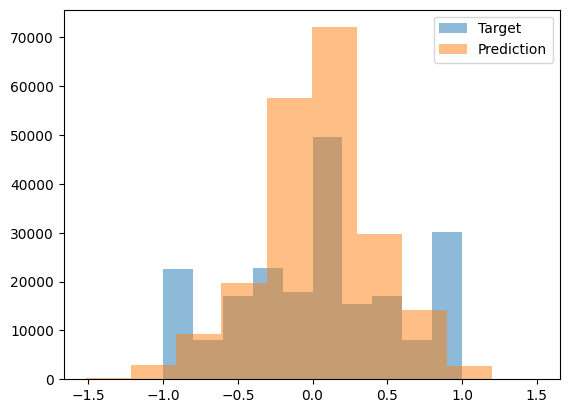

In [16]:
plt.hist(oof1['utility_agent1_true'], alpha=0.5, label='Target')
plt.hist(oof1['utility_agent1_pred'], alpha=0.5, label='Prediction')
plt.legend()
plt.show()

***
### inference

In [17]:
import os
import polars as pl
sys.path.append("../data/raw/")
import kaggle_evaluation.mcts_inference_server

In [18]:
def predict(test: pl.DataFrame, sample_sub: pl.DataFrame):
    # Convert Polars DataFrame to Pandas DataFrame
    test_pd = test.to_pandas()
    
    # Process the test data
    test_processed = process_test_data(
        test_pd,
        numerical_cols,
        categorical_cols,
        encoder,
        scaler
    )

    # Create feature types list for XGBoost
    feature_types = [
        "c" if col in categorical_cols else "q" 
        for col in numerical_cols + categorical_cols
    ]

    # Create XGBoost DMatrix for test data
    test_dmatrix = xgb.DMatrix(
        data=test_processed[numerical_cols + categorical_cols],
        feature_types=feature_types,
        enable_categorical=True
    )

    # Average predictions from all models
    predictions = np.mean([
        model.predict(test_dmatrix)
        for model in trained_models
    ], axis=0)
    predictions = np.clip(predictions, -1, 1)
        
    # Create the submission DataFrame
    submission = sample_sub.with_columns(pl.Series("utility_agent1", predictions))
    
    return submission

In [19]:
inference_server = kaggle_evaluation.mcts_inference_server.MCTSInferenceServer(predict)

if os.getenv('KAGGLE_IS_COMPETITION_RERUN'):
    inference_server.serve()
else:
    inference_server.run_local_gateway(
        (
            '../data/raw/test.csv',
            '../data/raw/sample_submission.csv'
        )
    )

In [20]:
# Save all artifacts needed for prediction
xgboost_predict = {
    'models': trained_models,
    'numerical_cols': numerical_cols,
    'categorical_cols': categorical_cols,
    'encoder': encoder,
    'scaler': scaler
}

with open(f'./xgboost_predict_{fs_type}.pkl', 'wb') as f:
    pickle.dump(xgboost_predict, f)

***